# Inversion with GANs

## 1. Definition

**Inversion with GANs** refers to the process of finding a latent code $z$ such that a pretrained generator $G$ can reproduce or closely approximate a given image $x$.  
The goal is:

$ G(z^\*) \approx x $

where $z^\*$ is the **inverted latent** corresponding to $x$.

Given:

- Generator: $G : \mathcal{Z} \rightarrow \mathcal{X}$
- Latent variable: $z \sim p(z)$
- Target image: $x \in \mathcal{X}$

Inversion finds:

$ z^\* = \underset{z}{\arg\min} \; \mathcal{L}(G(z), x) $

This allows analysis, editing, and manipulation in the GAN latent space.

---

## 2. Why Inversion is Needed

GANs learn a powerful mapping:

$ z \rightarrow x $

but do **not** provide the inverse:

$ x \rightarrow z $

However, many downstream applications require latent inference:

- semantic editing  
- style transfer  
- image reconstruction  
- understanding latent structure  

Thus, inversion techniques approximate $G^{-1}$.

---

## 3. Types of GAN Inversion

### 3.1 Optimization-based inversion  
Find $z^\*$ by solving:

$ z^\* = \underset{z}{\arg\min} \; \mathcal{L}(G(z), x) $

Common reconstruction losses:

$ \mathcal{L}_{\ell_2} = \lVert G(z) - x \rVert_2^2 $

$ \mathcal{L}_{\text{per}} = \lVert \phi(G(z)) - \phi(x) \rVert_2^2 $

where $\phi$ is a perceptual feature extractor.

---

### 3.2 Encoder-based inversion  
Learn an encoder $E$ such that:

$ E(x) \approx z $

and

$ G(E(x)) \approx x $

Training objective:

$ \mathcal{L}_{E} = \mathbb{E}_{z \sim p(z)}\left[ \lVert E(G(z)) - z \rVert_2^2 \right] $

Also known as **latent regression** or **GAN inversion via encoding**.

---

### 3.3 Hybrid inversion  
First use encoder output $z_0 = E(x)$, then refine via optimization:

$ z^\* = \underset{z}{\arg\min} \; \mathcal{L}(G(z), x) \quad \text{with } z_0 \text{ as initialization} $

This gives both **accuracy** and **speed**.

---

## 4. Derivation of Optimization-based Inversion

### Step 1: Define generator mapping

$ x = G(z) $

We want to find $z$ such that $G(z)$ matches a target $x_t$.

---

### Step 2: Formulate reconstruction objective

Define a loss function measuring closeness:

$ \mathcal{L}(z) = \mathcal{L}_{\text{pix}}(z) + \lambda \mathcal{L}_{\text{per}}(z) $

where:

$ \mathcal{L}_{\text{pix}}(z) = \lVert G(z) - x_t \rVert_2^2 $

$ \mathcal{L}_{\text{per}}(z) = \lVert \phi(G(z)) - \phi(x_t) \rVert_2^2 $

---

### Step 3: Gradient descent in latent space

$ z_{k+1} = z_k - \eta \frac{\partial}{\partial z_k}\mathcal{L}(G(z_k), x_t) $

This attempts to minimize reconstruction error.

---

### Step 4: Solution interpretation

After convergence:

$ z^\* = \arg\min_z \mathcal{L}(G(z), x_t) $

This $z^\*$ is the **inverse projection** of $x_t$ into the GAN latent space.

---

## 5. Summary

- GAN inversion finds a latent code $z^\*$ such that $G(z^\*)$ reconstructs the target image.  
- Three major families exist: optimization-based, encoder-based, and hybrid methods.  
- Optimization solves:

  $ z^\* = \arg\min_z \mathcal{L}(G(z), x) $

- Encoder-based inversion solves:

  $ E(G(z)) \approx z $

- Inversion enables editing, analysis, and reconstruction in the GAN’s latent space.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


100%|██████████| 9.91M/9.91M [00:00<00:00, 57.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.81MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]


'cuda'

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

G = Generator().to(device)


In [ ]:
optimizer_G = optim.Adam(G.parameters(), lr=2e-3)
criterion = nn.MSELoss()

for epoch in range(2):   # short training just for demo
    for imgs, _ in loader:
        imgs = imgs.to(device)

        z = torch.randn(imgs.size(0), 100).to(device)
        fake = G(z)

        loss = criterion(fake.mean(), imgs.mean())  # crude matching loss

        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()

    print("Epoch:", epoch, "loss:", loss.item())


Epoch: 0 loss: 1.6382362446165644e-05
Epoch: 1 loss: 2.2456863007391803e-05


In [ ]:
for p in G.parameters():
    p.requires_grad = False


In [ ]:
real_imgs, _ = next(iter(loader))
real_imgs = real_imgs[:8].to(device)   # invert 8 samples


In [ ]:
z = torch.randn(real_imgs.size(0), 100, requires_grad=True, device=device)


In [ ]:
optimizer_z = optim.Adam([z], lr=0.05)
recon_loss = nn.MSELoss()

loss_trace = []

for step in range(300000):  # latent optimization
    optimizer_z.zero_grad()

    recon = G(z)
    loss = recon_loss(recon, real_imgs)

    loss.backward()
    optimizer_z.step()

    loss_trace.append(loss.item())

    if step % 50 == 0:
        print("Step:", step, "recon loss:", loss.item())


Streaming output truncated to the last 5000 lines.
Step: 50000 recon loss: 0.3437941372394562
Step: 50050 recon loss: 0.3437897264957428
Step: 50100 recon loss: 0.3437921106815338
Step: 50150 recon loss: 0.34378448128700256
Step: 50200 recon loss: 0.34378817677497864
Step: 50250 recon loss: 0.3437868058681488
Step: 50300 recon loss: 0.3437948226928711
Step: 50350 recon loss: 0.3437921404838562
Step: 50400 recon loss: 0.3437953293323517
Step: 50450 recon loss: 0.34379151463508606
Step: 50500 recon loss: 0.3437904119491577
Step: 50550 recon loss: 0.3437848687171936
Step: 50600 recon loss: 0.34378781914711
Step: 50650 recon loss: 0.3437957763671875
Step: 50700 recon loss: 0.3437833786010742
Step: 50750 recon loss: 0.34378376603126526
Step: 50800 recon loss: 0.3437967896461487
Step: 50850 recon loss: 0.34378719329833984
Step: 50900 recon loss: 0.3437879979610443
Step: 50950 recon loss: 0.343790203332901
Step: 51000 recon loss: 0.34378907084465027
Step: 51050 recon loss: 0.34379062056541443

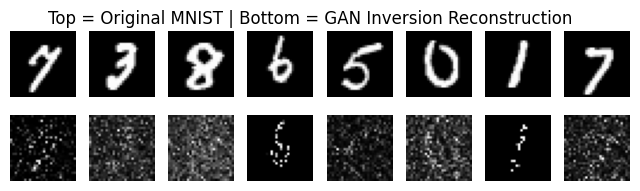

In [ ]:
recon_imgs = G(z).detach().cpu()
real_imgs_cpu = real_imgs.cpu()

plt.figure(figsize=(8,2))
for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(real_imgs_cpu[i][0], cmap="gray")
    plt.axis("off")

    plt.subplot(2, 8, 8+i+1)
    plt.imshow(recon_imgs[i][0], cmap="gray")
    plt.axis("off")

plt.suptitle("Top = Original MNIST | Bottom = GAN Inversion Reconstruction")
plt.show()


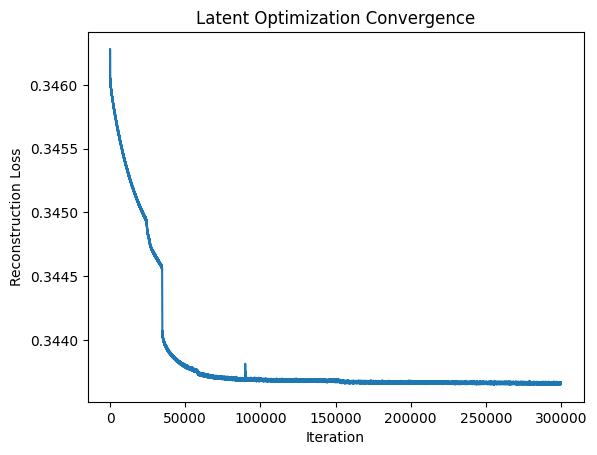

In [ ]:
plt.plot(loss_trace)
plt.xlabel("Iteration")
plt.ylabel("Reconstruction Loss")
plt.title("Latent Optimization Convergence")
plt.show()
